In [43]:
import sys
import os
import copy

ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, ".."))
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))
sys.path.insert(0, os.path.join(ROOT_DIR, "inerf_utils"))

import json
import torch
import numpy as np
import torchvision.transforms as T
import tqdm
import imageio
import cv2
import matplotlib.pyplot as plt
import wisp
from wisp.core import RenderBuffer, Rays


In [44]:
from wisp.framework import WispState
from kaolin.render.camera import Camera, blender_coords
from inerf_utils import *
from wisp.ops.raygen import generate_pinhole_rays, generate_centered_pixel_coords
from wisp.datasets import SampleRays
from wisp.trainers import MultiviewTrainer
from wisp.models.pipeline import Pipeline

def make_model(args, args_dict, extra_args, train_dataset, validation_dataset):
    pipeline = torch.load(args.pretrained)
    pipeline.to(extra_args['device'])
    scene_state = WispState()
    return pipeline
    # return pipeline

def gen_camera(pose, focal, w, h, far, extra_args):
    view_matrix = torch.zeros_like(pose)
    view_matrix[:3, :3] = pose[:3, :3].T
    view_matrix[:3, -1] = torch.matmul(-view_matrix[:3, :3], pose[:3, -1])
    view_matrix[3, 3] = 1.0

    x0 = 0.0
    y0 = 0.0
    print(view_matrix)
    camera = Camera.from_args(
        view_matrix=view_matrix,
        focal_x=focal,
        focal_y=focal,
        width=w,
        height=h,
        far=far,
        near=0.0,
        x0=x0,
        y0=y0,
        dtype=torch.float32,
        device=extra_args['device']
    )
    camera.change_coordinate_system(blender_coords())
    print(camera.extrinsics.parameters().reshape((4,4)))
    # mask = camera.extrinsics.gradient_mask('t')
    # camera.extrinsics.parameters.register_hook(lambda grad: grad * mask.float())
    
    return camera

def gen_rays_only(camera):
    ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
    rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
    rays = Rays.stack(rays)
    return rays

# def gen_rays(pose, focal, w, h, far):
#     ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
#     rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
#     # rays = Rays.stack(rays).to(dtype=torch.float)
    
#     return camera, rays

In [45]:
render_batch = 40000
def render_pipeline(pipeline, rays, lod_idx):
    rb = RenderBuffer(xyz=None, hit=None, normal=None, shadow=None, ao=None, dirs=None)
    for ray_pack in rays.split(render_batch):
        # print("haha")
        rb  += pipeline.tracer(pipeline.nef, rays=ray_pack, lod_idx=lod_idx)
    return rb

In [67]:
W, H = 800, 800
fx = (0.5 * H) / np.tan(0.5 * float(1.3213687585295282))
extra_args = {
  'resume' : True,
  'output' : './pose_estimation',
  'device' : 'cuda',
  'z_near' : 0.0,
  'z_far' : 10.0,
  'focal' : fx,
  'lrate' : 5e-3,
  'epochs': 500, 
  'wait_epochs': 10,
  'boundary_th': 5
}


In [68]:

# def max_unc_sampling(pipelines, rays:Rays, patch_size=5):

#     rays = rays.reshape((W, H, -1))
#     # sampled_rays = Rays(torch.empty((0,3)), torch.empty((0, 3)), dist_min=extra_args['z_near'], dist_max=extra_args['z_far'])
#     total_loss = 0
#     for j in range(0, H, patch_size):
#         for i in range(0, W, patch_size):
#             # with torch.no_grad():
            
#             patch_rays = rays[i:(i+patch_size), j:(j+patch_size)]
#             patch_rays = patch_rays.reshape((patch_size**2, -1))

#             all_rgbs = torch.zeros((len(pipelines), patch_size*patch_size, 3), dtype=float)
#             for i, pipeline in enumerate(pipelines):
#                 rb = render_pipeline(pipeline, patch_rays, None)
#                 all_rgbs[i,:,:] = rb.rgb

#             unc_loss = 1-torch.mean(torch.var(all_rgbs, axis = 0))
#             total_loss += unc_loss
#             unc_loss.backward()

#             # # print(all_rgbs)
#             # # print(unc_loss)
#             # # print(torch.max(unc_loss))
#             # max_unc = torch.max(unc_loss)
#             # ind = torch.argmax(unc_loss)
#             # # print(max_unc - torch.mean(unc_loss))
#             # max_unc_ray = patch_rays[ind:ind+1]
#             # # print(sampled_rays, max_unc_ray.to('cpu'))
#             # sampled_rays = Rays.cat([sampled_rays, max_unc_ray.to('cpu')])
#             # del(all_rgbs)
#     # print(sampled_rays)
#     print(total_loss)
#     # return sampled_rays
            
            

def batch_backwards(pipelines, rays:Rays, batch_size=4000):

    total_loss = 0
    
    for patch_rays in rays.split(batch_size):
            all_rgbs = torch.zeros((len(pipelines), batch_size, 3), dtype=float)
            for i, pipeline in enumerate(pipelines):
                rb = render_pipeline(pipeline, patch_rays, None)
                all_rgbs[i,:,:] = rb.rgb

            unc_loss = -torch.mean(torch.var(all_rgbs, axis = 0))
            total_loss += unc_loss.item()
            unc_loss.backward(retain_graph=True)
    # print(total_loss)
    return total_loss
            


def batch_backwards2(pipelines, camera, batch_size=4000):

    total_loss = 0
    patch = 0
    while True:
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))
        all_patch_rays = rays.split(batch_size)
        if len(all_patch_rays) == patch:
            break
        patch_rays = all_patch_rays[patch]

        all_rgbs = torch.zeros((len(pipelines), batch_size, 3), dtype=float)
        for i, pipeline in enumerate(pipelines):
            rb = render_pipeline(pipeline, patch_rays, None)
            all_rgbs[i,:,:] = rb.rgb

        unc_loss = -torch.mean(torch.var(all_rgbs, axis = 0))
        total_loss += unc_loss.item()
        unc_loss.backward()
        patch += 1
    # print(total_loss)
    return total_loss
            

In [69]:
def get_image(cam, pipeline):
    cam = copy.deepcopy(cam)

    rays = gen_rays_only(cam)
    rays = rays.reshape((rays.shape[0]**2, -1))

    rb = render_pipeline(pipeline, rays, lod_idx=None)
    rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
    alpha = rb.alpha.detach().cpu().numpy().reshape((H, W, 1))
    # v = np.concatenate([rgb, alpha], axis=2)

    # return v
    return rgb, alpha

In [70]:
argv_base = [
    '--config=../app/nerf/configs/nerf_hash.yaml',
    '--pretrained=path_to_model',
    '--valid-only'
]

In [71]:
argv_base

['--config=../app/nerf/configs/nerf_hash.yaml',
 '--pretrained=path_to_model',
 '--valid-only']

In [72]:
sys.argv

['/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/ipykernel_launcher.py',
 '--config=../app/nerf/configs/nerf_hash.yaml',
 '--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_5/20230424-184101/model.pth',
 '--valid-only']

In [73]:
model_name = "cheezit_single_side_env2_nobg_sam_scale10"
root_dir = '/home/saptarshi/dev/kaolin-wisp/_results_new/' + model_name + '/'

pipelines = []
for i in range(1,6):
    model_dir = os.path.join(root_dir, f"model_{i}")
    model_path = os.path.join(model_dir, list(sorted(os.listdir(model_dir)))[0], "model.pth")
    print(model_path)
    sys.argv[1:] = argv_base
    sys.argv[2] = sys.argv[2].replace("path_to_model", model_path)
    print(sys.argv[2])
    args, args_dict = parse_args()
    pipeline = make_model(
        args, args_dict, extra_args, None, None)
    pipelines.append(pipeline)

/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_1/20230424-183512/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_1/20230424-183512/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_2/20230424-183641/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_2/20230424-183641/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_3/20230424-183800/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_3/20230424-183800/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_4/20230424-183933/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_4/202304

In [74]:

cur_pose = torch.tensor([
    [
        -1.0, 
        -2.823936947407328e-17, 
        5.340285413173258e-16, 
        2.4463562574074363e-17
    ], 
    [
        3.5457582038357597e-16, 
        -0.04896000828076464, 
        0.9988007396819185, 
        0.3995202958290813
    ], 
    [
        -1.089239719165523e-17, 
        0.9988007396819186, 
        0.04896000828076479, 
        -0.08590599579648245
    ], 
    [
        0.0, 
        0.0, 
        0.0, 
        1.0
    ]
])
cur_pose_unscaled = cur_pose.clone()
cur_pose[..., :3, 3] *= 10/1.25

In [75]:
z_near, z_far = extra_args['z_near'], extra_args['z_far']
cur_cam = gen_camera(torch.clone(cur_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)
cur_cam.switch_backend('matrix_6dof_rotation')
current_pose = cur_cam.extrinsics.parameters().clone()
current_pose_named = cur_cam.extrinsics.named_params()

tensor([[-1.0000e+00,  3.5458e-16, -1.0892e-17, -9.4506e-16],
        [-2.8239e-17, -4.8960e-02,  9.9880e-01,  8.4291e-01],
        [ 5.3403e-16,  9.9880e-01,  4.8960e-02, -3.1587e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-1.0000e+00, -1.0892e-17, -3.5458e-16, -9.4506e-16],
        [-2.8239e-17,  9.9880e-01,  4.8960e-02,  8.4291e-01],
        [ 5.3403e-16,  4.8960e-02, -9.9880e-01, -3.1587e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


In [76]:
(torch.inverse(cur_pose))

tensor([[-1.0000e+00,  5.3477e-16, -2.0595e-18, -1.5149e-15],
        [-2.8239e-17, -4.8960e-02,  9.9880e-01,  8.4291e-01],
        [ 3.5362e-16,  9.9880e-01,  4.8960e-02, -3.1587e+00],
        [-6.6174e-24,  1.8626e-08, -2.3283e-10,  1.0000e+00]])

In [77]:
def create_vid(imgs, path):
    out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'DIVX'), 10, (W,H))
    for i in range(len(imgs)):
        img = imgs[i]
        img = (img * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(img)

In [78]:
from matplotlib.animation import FuncAnimation
def animate_plot(xs, ys, path, xlabel = "x", ylabel = "y", title = "plot"):
    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)

    ax.set_xlim(min(xs), max(xs))
    ax.set_ylim(min(ys), max(ys))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        x = xs[:i]
        y = ys[:i]
        line.set_data(x, y)
        return line,

    anim = FuncAnimation(fig, animate, init_func=init, frames=len(xs), interval=100, blit=True)

    anim.save(path, writer='ffmpeg')


In [79]:
def merge_horizontal(video1_path, video2_path, out_path):
    import cv2
    video1 = cv2.VideoCapture(video1_path)
    video2 = cv2.VideoCapture(video2_path)

        
    # Get video properties
    fps = int(video1.get(cv2.CAP_PROP_FPS))
    frame_width = int(video1.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    num_frames = int(video1.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_height_2 = int(video2.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width_2 = int(video2.get(cv2.CAP_PROP_FRAME_WIDTH))

    resize_ratio = frame_height / frame_height_2

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    output_video = cv2.VideoWriter(out_path, fourcc, fps, (frame_width + int(frame_width_2 * resize_ratio) , frame_height))

    # Loop through the frames and merge them side by side
    for _ in range(num_frames):
        ret1, frame1 = video1.read()
        ret2, frame2 = video2.read()

        if ret1 and ret2:
            if resize_ratio != 1.0:
                frame2 = cv2.resize(frame2, (0, 0), fx = resize_ratio, fy = resize_ratio)

            merged_frame = cv2.hconcat([frame1, frame2])
            output_video.write(merged_frame)
        else:
            break

    video1.release()
    video2.release()
    output_video.release()

    cv2.destroyAllWindows()


In [80]:
def object_touching_img_boundary(cam, offset=0):
    alphas = get_image(cam, pipeline=pipelines[0])[1].squeeze()
    count = 0
    count += np.sum(alphas[offset, :])
    count += np.sum(alphas[H-1-offset, :] > 0)
    count += np.sum(alphas[:, offset] > 0)
    count += np.sum(alphas[:, W-1-offset] > 0)

    count -= ((alphas[offset, offset] > 0) + (alphas[offset, W-1-offset] > 0) + (alphas[H-1-offset, offset] > 0) + (alphas[H-1-offset, W-1-offset] > 0))

    if(count >= extra_args['boundary_th']):
        return True
    return False

def early_stopping(losses, best_loss):
    if len(losses) > extra_args["wait_epochs"] and np.min(np.array(losses[(len(losses)-extra_args["wait_epochs"]):len(losses)])) > best_loss:
        return True
    return False

def stopping_cond(losses, cam, best_loss):
    if(object_touching_img_boundary(cam)):
        print("Stop Condition 1 Reached")
        return True
    
    if early_stopping(losses, best_loss):
        print("Stop Condition 2 Reached")
        return True
    return False

In [81]:
import cv2
from IPython.display import Video
def optimize(camera, optimizer, max_epochs=100, vid_name=None, loss_vid_name=None, merge_vid_name=None):
    imgs = []
    losses = []
    prev_best_cam = None
    prev_best_loss = np.inf
    print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
    for ep in range(max_epochs):
        optimizer.zero_grad()
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))
        cur_loss = batch_backwards(pipelines, rays, 40000)
        print(ep, cur_loss)
        losses.append(cur_loss)
        optimizer.step()
        if stopping_cond(losses, camera, prev_best_loss):
            break
        if(prev_best_loss > cur_loss):
            prev_best_loss = cur_loss
            prev_best_cam = copy.deepcopy(camera)

        img = get_image(camera, pipeline=pipelines[0])[0]
        imgs.append(img)
    
    if vid_name:
        create_vid(imgs, f'results/videos/{vid_name}')
    
    if loss_vid_name:
        animate_plot(np.arange(len(losses)), losses, f'results/videos/{loss_vid_name}', "epochs", "loss", "loss v/s epoch while training")
    
    if vid_name and loss_vid_name and merge_vid_name:
        merge_horizontal(f'results/videos/{vid_name}', f'results/videos/{loss_vid_name}', f'results/videos/{merge_vid_name}')
        
    return prev_best_loss, prev_best_cam


In [82]:
def show_image_from_pose(pose):
    print(pose)
    z_near, z_far = extra_args['z_near'], extra_args['z_far']
    cam = gen_camera(torch.clone(pose).detach(), extra_args['focal'], W, H, z_far, extra_args)
    # cam.switch_backend('matrix_6dof_rotation')
    img = get_image(cam, pipelines[0])[0]
    plt.imshow(img)
    plt.show()
    return img


tensor([[-0.8806, -0.1655, -0.4439, -1.4502],
        [-0.3394,  0.8742,  0.3473,  1.5378],
        [ 0.3306,  0.4565, -0.8261, -2.5557],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[-0.8806, -0.3394,  0.3306,  0.0896],
        [-0.1655,  0.8742,  0.4565, -0.4179],
        [-0.4439,  0.3473, -0.8261, -3.2889],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[-0.8806,  0.3306,  0.3394,  0.0896],
        [-0.1655,  0.4565, -0.8742, -0.4179],
        [-0.4439, -0.8261, -0.3473, -3.2889],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


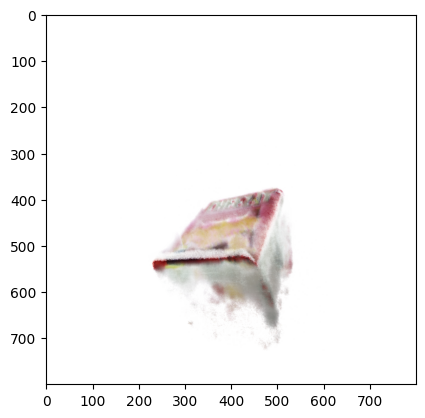

In [83]:
x = torch.tensor([
                [
                    -0.8806495529218502,
                    -0.16553153168942175,
                    -0.4439095369048737,
                    -0.18127308785915383
                ],
                [
                    -0.3393612688949051,
                    0.8742140185471973,
                    0.3472517515428839,
                    0.1922243535518647
                ],
                [
                    0.33059082581430693,
                    0.4564528034661579,
                    -0.8260511752278427,
                    -0.31945815682411205
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0000000000000002
                ]
            ])
x[..., :3, 3] *= 10/1.25
img = show_image_from_pose(x)


In [84]:
img2 = cv2.imread("/home/saptarshi/dev/CustomComposer/workdir/merged_images_stop_conds_1/train/rgb_0001_iter1.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
print(img2.shape)
plt.imshow(img2)

[ WARN:0@94.452] global loadsave.cpp:248 findDecoder imread_('/home/saptarshi/dev/CustomComposer/workdir/merged_images_stop_conds_1/train/rgb_0001_iter1.png'): can't open/read file: check file path/integrity


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [85]:
plt.imshow((img*255).astype(np.uint8) - img2)

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [86]:
# import pickle as pkl
# x = pkl.load(open("/home/saptarshi/dev/CustomComposer/workdir/output.pkl", 'rb')).reshape((4,4))
# print(x)
# x = torch.tensor(np.linalg.inv(x))
# print(x)
# # x = torch.tensor([[-0.17513783,  0.5093843 , -0.8425285 , -0.32953185],
# #        [ 0.1749943 ,  0.8582348 ,  0.4825038 ,  0.22840963],
# #        [ 0.96886724, -0.06293302, -0.23944874, -0.11711518],
# #        [ 0.        ,  0.        ,  0.        ,  1.        ]])
# x[..., :3, 3] *= 10/1.25
# show_image_from_pose(x)

In [87]:
from scipy.spatial.transform import Rotation as R
def calculate_initial_poses(object_center, cam_pose):
    def create_pose(rot, loc):
        pose = torch.eye(4)
        pose[..., :3, :3] = rot
        pose[..., :3, 3] = loc*10/1.25
        return pose

    print((cam_pose[..., :3, 3] - object_center)**2)
    d = torch.sqrt(torch.sum((cam_pose[..., :3, 3] - object_center)**2))
    r11 =  R.from_rotvec(np.pi/2 * np.array([1, 0, 0]))
    r12 =  R.from_rotvec(np.pi * np.array([0, 1, 0]))
    front_facing_rot = torch.tensor(r11.as_matrix() @ r12.as_matrix())

    # UP
    r2 =  R.from_rotvec(-np.pi/4 * np.array([1, 0, 0]))
    rot1 = front_facing_rot @ r2.as_matrix()
    loc1 = object_center + d/np.sqrt(2)*torch.tensor([0, 1, 1])
    
    pose1 = create_pose(rot1, loc1)
    show_image_from_pose(pose1)

    #DOWN
    r2 =  R.from_rotvec(np.pi/4 * np.array([1, 0, 0]))
    rot2 = front_facing_rot @ r2.as_matrix()
    loc2 = object_center + d/np.sqrt(2) * torch.tensor([0, 1, -1])

    pose2 = create_pose(rot2, loc2)
    show_image_from_pose(pose2)

    # LEFT
    r2 =  R.from_rotvec(-np.pi/4 * np.array([0, 1, 0]))
    rot3 = front_facing_rot @ r2.as_matrix()
    loc3 = object_center + d/np.sqrt(2) * torch.tensor([1, 1, 0])

    pose3 = create_pose(rot3, loc3)
    show_image_from_pose(pose3)

    # RIGHT
    r2 =  R.from_rotvec(np.pi/4 * np.array([0, 1, 0]))
    rot4 = front_facing_rot @ r2.as_matrix()
    loc4 = object_center + d/np.sqrt(2) * torch.tensor([-1, 1, 0])

    pose4 = create_pose(rot4, loc4)
    show_image_from_pose(pose4)

    return [pose1, pose2, pose3, pose4]
    

tensor([5.9847e-34, 1.2216e-01, 7.3798e-03])
tensor([[-1.0000e+00, -8.6596e-17,  8.6596e-17,  0.0000e+00],
        [ 1.2246e-16, -7.0711e-01,  7.0711e-01,  2.4360e+00],
        [-2.7193e-32,  7.0711e-01,  7.0711e-01,  2.0360e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-1.0000e+00,  1.2246e-16, -2.7193e-32, -2.9833e-16],
        [-8.6596e-17, -7.0711e-01,  7.0711e-01,  2.8284e-01],
        [ 8.6596e-17,  7.0711e-01,  7.0711e-01, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-1.0000e+00, -2.7193e-32, -1.2246e-16, -2.9833e-16],
        [-8.6596e-17,  7.0711e-01,  7.0711e-01,  2.8284e-01],
        [ 8.6596e-17,  7.0711e-01, -7.0711e-01, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


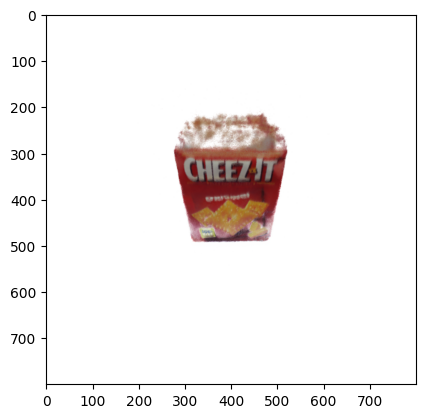

tensor([[-1.0000e+00,  8.6596e-17,  8.6596e-17,  0.0000e+00],
        [ 1.2246e-16,  7.0711e-01,  7.0711e-01,  2.4360e+00],
        [-2.7193e-32,  7.0711e-01, -7.0711e-01, -2.0360e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-1.0000e+00,  1.2246e-16, -2.7193e-32, -2.9833e-16],
        [ 8.6596e-17,  7.0711e-01,  7.0711e-01, -2.8284e-01],
        [ 8.6596e-17,  7.0711e-01, -7.0711e-01, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-1.0000e+00, -2.7193e-32, -1.2246e-16, -2.9833e-16],
        [ 8.6596e-17,  7.0711e-01, -7.0711e-01, -2.8284e-01],
        [ 8.6596e-17, -7.0711e-01, -7.0711e-01, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


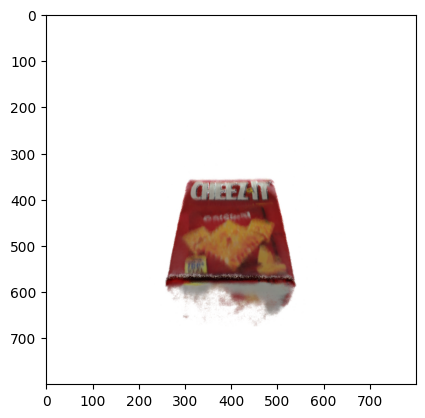

tensor([[-7.0711e-01,  0.0000e+00,  7.0711e-01,  2.0360e+00],
        [ 7.0711e-01,  2.2204e-16,  7.0711e-01,  2.4360e+00],
        [-1.5701e-16,  1.0000e+00, -1.5701e-16,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-7.0711e-01,  7.0711e-01, -1.5701e-16, -2.8284e-01],
        [ 0.0000e+00,  2.2204e-16,  1.0000e+00, -5.4091e-16],
        [ 7.0711e-01,  7.0711e-01, -1.5701e-16, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-7.0711e-01, -1.5701e-16, -7.0711e-01, -2.8284e-01],
        [ 0.0000e+00,  1.0000e+00, -2.2204e-16, -5.4091e-16],
        [ 7.0711e-01, -1.5701e-16, -7.0711e-01, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


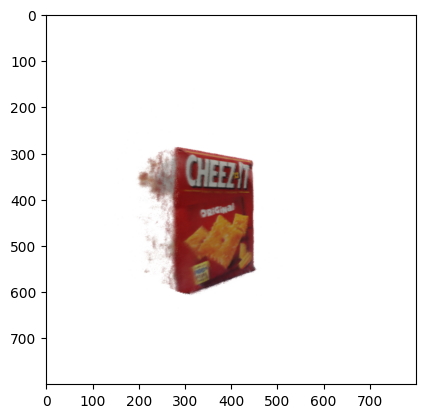

tensor([[-7.0711e-01,  0.0000e+00, -7.0711e-01, -2.0360e+00],
        [-7.0711e-01,  2.2204e-16,  7.0711e-01,  2.4360e+00],
        [ 1.5701e-16,  1.0000e+00, -1.5701e-16,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-7.0711e-01, -7.0711e-01,  1.5701e-16,  2.8284e-01],
        [ 0.0000e+00,  2.2204e-16,  1.0000e+00, -5.4091e-16],
        [-7.0711e-01,  7.0711e-01, -1.5701e-16, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-7.0711e-01,  1.5701e-16,  7.0711e-01,  2.8284e-01],
        [ 0.0000e+00,  1.0000e+00, -2.2204e-16, -5.4091e-16],
        [-7.0711e-01, -1.5701e-16, -7.0711e-01, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


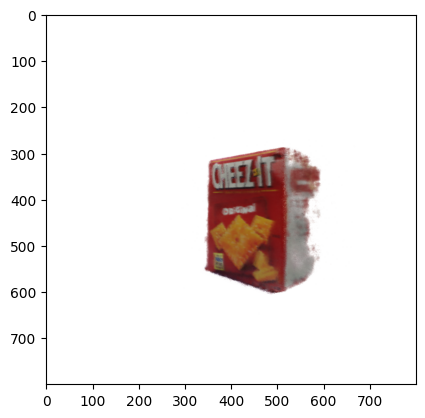

In [88]:
initial_poses = calculate_initial_poses(torch.tensor([0, 0.05, 0]), cur_pose_unscaled)

In [89]:
best_cam = None
min_loss = np.inf
losses = None
specify_run = f"{extra_args['epochs']}_{extra_args['lrate']}_stop{extra_args['wait_epochs']}"
for i, initial_pose in enumerate(initial_poses):
    camera = gen_camera(torch.clone(initial_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)
    camera.switch_backend('matrix_6dof_rotation')
    camera.extrinsics.requires_grad = True

    optimizer = torch.optim.Adam(params=[camera.extrinsics.parameters()], lr=extra_args['lrate'])
    loss, cam  = optimize(camera, optimizer, extra_args["epochs"], f"pose{i+1}_{specify_run}_vid.avi", f"pose{i+1}_{specify_run}_vid_loss.avi", f"pose{i+1}_{specify_run}_merged.avi")
    if loss < min_loss:
        best_cam = copy.deepcopy(cam)
        min_loss = loss

tensor([[-1.0000e+00,  1.2246e-16, -2.7193e-32, -2.9833e-16],
        [-8.6596e-17, -7.0711e-01,  7.0711e-01,  2.8284e-01],
        [ 8.6596e-17,  7.0711e-01,  7.0711e-01, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-1.0000e+00, -2.7193e-32, -1.2246e-16, -2.9833e-16],
        [-8.6596e-17,  7.0711e-01,  7.0711e-01,  2.8284e-01],
        [ 8.6596e-17,  7.0711e-01, -7.0711e-01, -3.1622e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
tensor([-9.4506e-16,  8.4291e-01, -3.1587e+00], device='cuda:0') tensor([-2.9833e-16,  2.8284e-01, -3.1622e+00], device='cuda:0',
       grad_fn=<IndexBackward0>)
0 -0.016636166476621243
1 -0.017079346952455946


KeyboardInterrupt: 

In [69]:
merge_horizontal("results/videos/pose1_500_vid.avi", "results/videos/pose1_500_vid_loss.avi", "results/videos/pose1_500_merged.avi")

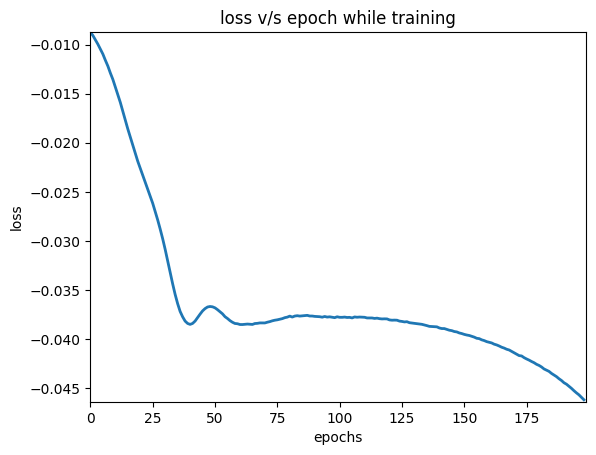

In [23]:
animate_plot(np.arange(len(losses)), losses, f'results/videos/pose0_vid_loss.avi', "epochs", "loss", "loss v/s epoch while training")


In [55]:
camera.extrinsics.requires_grad = False
print(camera.extrinsics.parameters())
camera.extrinsics.switch_backend("matrix_se3")
print(camera.extrinsics.parameters().reshape((4, 4)))
camera.extrinsics.switch_backend("matrix_6dof_rotation")


tensor([[-0.9319,  0.2598, -0.2530, -0.1112,  0.4594,  0.8812, -0.1709,  0.7563,
         -2.8435]], device='cuda:0')
tensor([[-0.9319,  0.2598, -0.2530, -0.1709],
        [-0.1112,  0.4594,  0.8812,  0.7563],
        [ 0.3452,  0.8494, -0.3992, -2.8435],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


In [34]:
def batch_loss(rays, pipelines, batch_size):
    total_loss = 0
    for patch_rays in rays.split(batch_size):
            all_rgbs = torch.zeros((len(pipelines), batch_size, 3), dtype=float)
            for i, pipeline in enumerate(pipelines):
                rb = render_pipeline(pipeline, patch_rays, None)
                all_rgbs[i,:,:] = rb.rgb

            unc_loss = -torch.mean(torch.var(all_rgbs, axis = 0))
            total_loss += unc_loss.item()
    print(total_loss)
    return total_loss
            



tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.7071,  0.7071, -1.9311],
        [ 0.0000,  0.7071,  0.7071, -1.9318],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)
tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7071,  0.7071, -1.9311],
        [ 0.0000,  0.7071, -0.7071, -1.9318],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


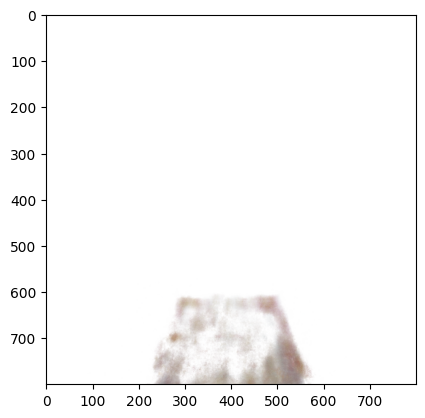

Rays(origins=tensor([[[ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         ...,
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04]],

        [[ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         ...,
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04]],

        [[ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         ...,
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04],
         [ 0.0000e+00,  2.7315e+00, -5.5170e-04]],

        ...,

        [[ 0.0000e+00,  2

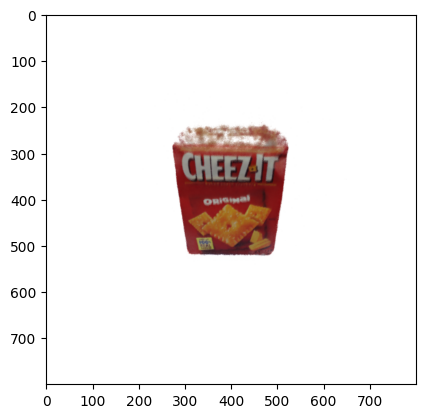

In [82]:
center_location = torch.tensor([0, 0, 0.2])
d = np.sqrt(((cur_pose[..., :3, 3]) - center_location)**2)
loc = center_location + d/np.sqrt(2)*torch.tensor([0, 1, 1])
pose1 = torch.tensor([
    [
        -1,
        0,
        0,
        loc[0]
    ],
    [
        0,
        -1/np.sqrt(2),
        1/np.sqrt(2),
        loc[1]
    ],
    [
        0,
        1/np.sqrt(2),
        1/np.sqrt(2),
        loc[2]
    ],
    [
        0,
        0,
        0,
        1
    ],

])

pose2 = torch.tensor( [
                [
                    -0.9995014259114849,
                    0.017827861805323246,
                    -0.026058912954277216,
                    -0.010423559328692432
                ],
                [
                    -0.031573716932098754,
                    -0.5643609630660327,
                    0.8249241200051503,
                    0.3299696497695737
                ],
                [
                    -1.0016903827879961e-16,
                    0.8253356109551012,
                    0.5646424791754244,
                    0.19202898935801416
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0
                ]
            ])
pose1[..., :3, 3] *= 10/1.25
pose2[..., :3, 3] *= 10/1.25
z_near, z_far = extra_args['z_near'], extra_args['z_far']

cam1 = gen_camera(torch.clone(pose1).detach(), extra_args['focal'], W, H, z_far, extra_args)
cam1.switch_backend('matrix_6dof_rotation')
rays1 = gen_rays_only(cam1)
plt.imshow(get_image(cam1, pipelines[0])[0])
plt.show()
print(rays1)
cam2 = gen_camera(torch.clone(pose2).detach(), extra_args['focal'], W, H, z_far, extra_args)
cam2.switch_backend('matrix_6dof_rotation')
rays2 = gen_rays_only(cam2)
print(rays2)
plt.imshow(get_image(cam2, pipelines[0])[0])
plt.show()

In [28]:
import scipy

In [66]:
# res, _ = scipy.spatial.transform.Rotation.align_vectors([[0, -1/np.sqrt(2), -1/np.sqrt(2)]], [[0, -1/np.sqrt(2), 1/np.sqrt(2)]])
res, _ = scipy.spatial.transform.Rotation.align_vectors([[0, 0, -1]], [[0, -1, 0]])

/tmp/ipykernel_3295961/1334502667.py:2: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  res, _ = scipy.spatial.transform.Rotation.align_vectors([[0, 0, -1]], [[0, -1, 0]])


tensor([[-1.0000,  0.0000,  0.0000],
        [ 0.0000, -0.7071,  0.7071],
        [ 0.0000,  0.7071,  0.7071]], dtype=torch.float64)
[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
tensor([[-1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7071,  0.7071],
        [ 0.0000,  0.7071, -0.7071]], dtype=torch.float64)
tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7071,  0.7071, -1.5858],
        [ 0.0000,  0.7071, -0.7071, -1.6103],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7071, -0.7071, -1.5858],
        [ 0.0000, -0.7071, -0.7071, -1.6103],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


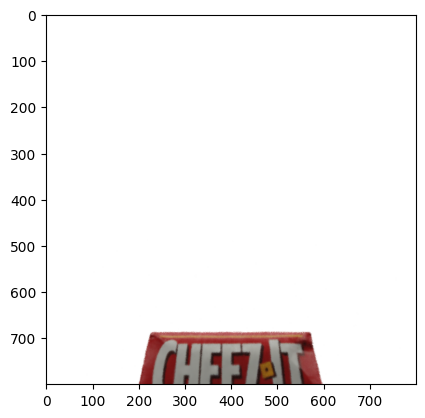

In [67]:
print(pose1[..., :3, :3])
print(res.as_matrix())
print(pose1[..., :3, :3] @ res.as_matrix())
rotn = pose1[..., :3, :3] @ res.as_matrix()
locn = center_location + d/np.sqrt(2)*torch.tensor([0, 1, -1])
pose3 = torch.zeros((4,4))
pose3[:3, :3] = rotn
pose3[:3, 3] = locn*10/1.25
pose3[3, :] = torch.tensor([0, 0, 0, 1])

cam3 = gen_camera(torch.clone(pose3).detach(), extra_args['focal'], W, H, z_far, extra_args)
cam3.switch_backend('matrix_6dof_rotation')
# raysn = gen_rays_only(camn)
plt.imshow(get_image(cam3, pipelines[0])[0])
plt.show()

In [35]:

def loss_off(camera, off_x, off_y, off_z):
    cam2 = copy.deepcopy(camera)
    # print(cam2.extrinsics._backend.params)
    cam2.extrinsics._backend.params[0,6] += off_x
    cam2.extrinsics._backend.params[0,7] += off_y
    cam2.extrinsics._backend.params[0,8] += off_z
    print(cam2.extrinsics._backend.params)
    # plt.imshow(get_image(cam2, pipeline=pipelines[0])[0])
    # plt.show()
    rays = gen_rays_only(cam2)
    rays = rays.reshape((rays.shape[0]**2, -1))
    return (batch_loss(rays, pipelines, 40000)/16)
    

In [18]:
cam1.intrinsics.named_params()

[{'x0': 0.0,
  'y0': 0.0,
  'focal_x': 514.6666259765625,
  'focal_y': 514.6666259765625}]

In [160]:
# all_ys = all_ys+ys
# all_ys = all_ys[0:42]

In [140]:
# print(torch.cuda.memory_summary())

In [165]:
import plotly.express as px
xs = np.linspace(-0.1, 0.1, 100)
ys = [loss_off(camera, 0, 0, x) for x in xs]

tensor([[-0.9319,  0.2598, -0.2530, -0.1112,  0.4594,  0.8812, -0.1709,  0.7563,
         -2.9435]], device='cuda:0')
-0.03607498266413982
tensor([[-0.9319,  0.2598, -0.2530, -0.1112,  0.4594,  0.8812, -0.1709,  0.7563,
         -2.9415]], device='cuda:0')
-0.0360801022976389
tensor([[-0.9319,  0.2598, -0.2530, -0.1112,  0.4594,  0.8812, -0.1709,  0.7563,
         -2.9395]], device='cuda:0')
-0.0361337257088005
tensor([[-0.9319,  0.2598, -0.2530, -0.1112,  0.4594,  0.8812, -0.1709,  0.7563,
         -2.9375]], device='cuda:0')
-0.03621589303957636
tensor([[-0.9319,  0.2598, -0.2530, -0.1112,  0.4594,  0.8812, -0.1709,  0.7563,
         -2.9354]], device='cuda:0')
-0.036226712590597315
tensor([[-0.9319,  0.2598, -0.2530, -0.1112,  0.4594,  0.8812, -0.1709,  0.7563,
         -2.9334]], device='cuda:0')
-0.03629760643267761
tensor([[-0.9319,  0.2598, -0.2530, -0.1112,  0.4594,  0.8812, -0.1709,  0.7563,
         -2.9314]], device='cuda:0')
-0.036336711696767963
tensor([[-0.9319,  0.2598, 

In [156]:
ys

[-0.0027964764675651806]

In [161]:
len(all_ys)

50

In [166]:
fig = px.line(x=xs, y=ys)
fig

In [ ]:
# # print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
# import cv2
# from IPython.display import Video

# out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, (200,200))
# imgs = []

# # for ep in range(extra_args['epochs']):
# for ep in range(200):
#     optimizer.zero_grad()
#     rays = gen_rays_only(camera)
#     rays = rays.reshape((rays.shape[0]**2, -1))
    
#     # all_rgbs = torch.zeros((len(pipelines), W*H, 3), dtype=float)
#     all_rgbs = torch.zeros((len(pipelines), W*H, 3), dtype=float)


#     for i, pipeline in enumerate(pipelines):
#         # rb = render_pipeline(pipeline, rays, None)
#         rb = pipeline(rays)
#         # print(rb.rgb.shape)
#         all_rgbs[i,:,:] = rb.rgb
#     # print(all_rgbs)


#     # var = torch.var(all_rgbs, axis = 0)
#     # std = torch.sqrt(torch.mean(var, axis = -1))
#     # std = torch.mean(var, axis = -1)
#     # std.retain_grad()
#     # std.register_hook(lambda x : print('std', x.mean()))
#     # unc_loss = math.sqrt(3)-torch.mean(torch.sqrt(torch.sum(torch.var(all_rgbs, axis = 0), axis = -1)))

#     # dist_loss = torch.mean((current_pose - camera.extrinsics.parameters())**2)
#     # flip_loss = 


#     unc_loss = 1-torch.mean(torch.var(all_rgbs, axis = 0))
#     dist_loss = torch.mean((current_pose_named[0]['t'] - camera.extrinsics.t)**2)

#     loss = unc_loss 
#     # print(unc_loss, dist_loss, loss)

#     loss.backward()
#     optimizer.step()
#     # del(all_rgbs)
#     del(unc_loss)
#     del(dist_loss)

#     print(ep, loss.item())
#     # print(current_pose, camera.extrinsics.parameters())
#     # print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
#     # print(camera.intrinsics.named_params())
#     img = get_image(camera, pipeline=pipelines[0])[0]
#     imgs.append(img)
#     # plt.imshow(img)
#     # img = (img * 255).astype(np.uint8)
#     # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     # out.write(img)
#     # plt.show()



In [ ]:
cv2.imwrite('temp.png', img)

True

In [ ]:
imgs[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [ ]:
torch.isnan(var[:,2])

NameError: name 'var' is not defined

In [ ]:
torch.mean((current_pose - camera.extrinsics.parameters())**2)

tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
camera.extrinsics.named_params()[0]

{'R': tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
        grad_fn=<IndexBackward0>),
 't': tensor([nan, nan, nan], device='cuda:0', grad_fn=<IndexBackward0>)}

In [ ]:
camera.intrinsics.named_params()

[{'x0': 0.0,
  'y0': 0.0,
  'focal_x': 128.66665649414062,
  'focal_y': 128.66665649414062}]

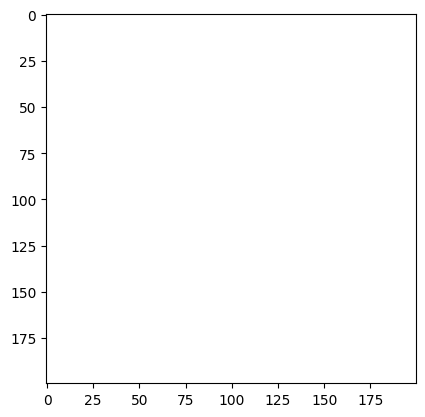

In [ ]:
plt.imshow(get_image(camera, pipeline=pipelines[0])[0])


In [ ]:
torch.tensor([[-1.0, -2.823936947407328e-17, 5.340285413173258e-16, 2.4463562574074363e-17], [3.5457582038357597e-16, -0.04896000828076464, 0.9988007396819185, 0.3995202958290813], [-1.089239719165523e-17, 0.9988007396819186, 0.04896000828076479, -0.08590599579648245], [0.0, 0.0, 0.0, 1.0]])

tensor([[-1.0000e+00, -2.8239e-17,  5.3403e-16,  2.4464e-17],
        [ 3.5458e-16, -4.8960e-02,  9.9880e-01,  3.9952e-01],
        [-1.0892e-17,  9.9880e-01,  4.8960e-02, -8.5906e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
gen_rays_only(camera)

Rays(origins=tensor([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        ...,

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, n

In [ ]:
camera.view_projection_matrix()

tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]], device='cuda:0', grad_fn=<BmmBackward0>)

In [ ]:
camera.named_params()

[{'R': tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
         grad_fn=<IndexBackward0>),
  't': tensor([nan, nan, nan], device='cuda:0', grad_fn=<IndexBackward0>),
  'x0': 0.0,
  'y0': 0.0,
  'focal_x': 128.66665649414062,
  'focal_y': 128.66665649414062}]

In [ ]:
initial_pose

tensor([[-1.0000e+00, -4.6265e-16,  4.7207e-16,  1.4103e-16],
        [ 5.3111e-16, -6.9423e-01,  7.1976e-01,  2.3032e+00],
        [-1.3052e-16,  7.1976e-01,  6.9423e-01,  1.3776e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
torch.inverse(camera.extrinsics.parameters().reshape((4,4)))

RuntimeError: shape '[4, 4]' is invalid for input of size 9

In [ ]:
camera.extrinsics.named_params()

In [ ]:
z_near, z_far = extra_args['z_near'], extra_args['z_far']
camera = gen_camera(torch.clone(initial_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)


In [ ]:
camera.extrinsics.t

tensor([[[-1.1280e-15],
         [ 7.5927e-01],
         [-3.2677e+00]]], device='cuda:0', grad_fn=<SliceBackward0>)